In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [ ]:
plt.rcParams['figure.dpi'] = 200
sns.set(rc={'axes.facecolor':'faded9'}, style='darkgrid')

In [ ]:
data = pd.read_csv('/content/sample_data/heart.csv')

In [ ]:
data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52.0,1.0,0.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,2.0,3.0,0.0
1,53.0,1.0,0.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0,0.0
2,70.0,1.0,0.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,0.0,3.0,0.0
3,61.0,1.0,0.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,2.0,1.0,3.0,0.0
4,62.0,0.0,0.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,1.0,3.0,2.0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6025 entries, 0 to 6024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       6025 non-null   float64
 1   sex       6025 non-null   float64
 2   cp        6025 non-null   float64
 3   trestbps  6025 non-null   float64
 4   chol      6025 non-null   float64
 5   fbs       6025 non-null   float64
 6   restecg   6025 non-null   float64
 7   thalach   6025 non-null   float64
 8   exang     6025 non-null   float64
 9   oldpeak   6025 non-null   float64
 10  slope     6025 non-null   float64
 11  ca        6025 non-null   float64
 12  thal      6025 non-null   float64
 13  target    6025 non-null   float64
dtypes: float64(14)
memory usage: 659.1 KB


In [ ]:

continous_features=['age','trestbps','chol','thalach','oldpeak']

all_non_continuous_features = [col for col in data.columns if col not in continous_features]
data[all_non_continuous_features] = data[all_non_continuous_features].astype('object')


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,6025.0,54.544066,9.110603,29.0,48.0,56.0,61.0,77.0
trestbps,6025.0,131.758008,17.616569,94.0,120.0,130.0,140.0,200.0
chol,6025.0,246.759004,50.892659,126.0,211.0,240.0,277.0,564.0
thalach,6025.0,149.298257,23.170492,71.0,133.0,152.0,166.0,202.0
oldpeak,6025.0,1.087884,1.181036,0.0,0.0,0.8,1.7,6.2


In [ ]:
data.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,6025.0,6025.0,6025.0,6025.0,6025.0,6025.0,6025.0,6025.0,6025.0
unique,2.0,4.0,2.0,3.0,2.0,3.0,5.0,4.0,2.0
top,1.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0
freq,3934.0,2646.0,4756.0,2811.0,3848.0,2643.0,2982.0,2878.0,4373.0


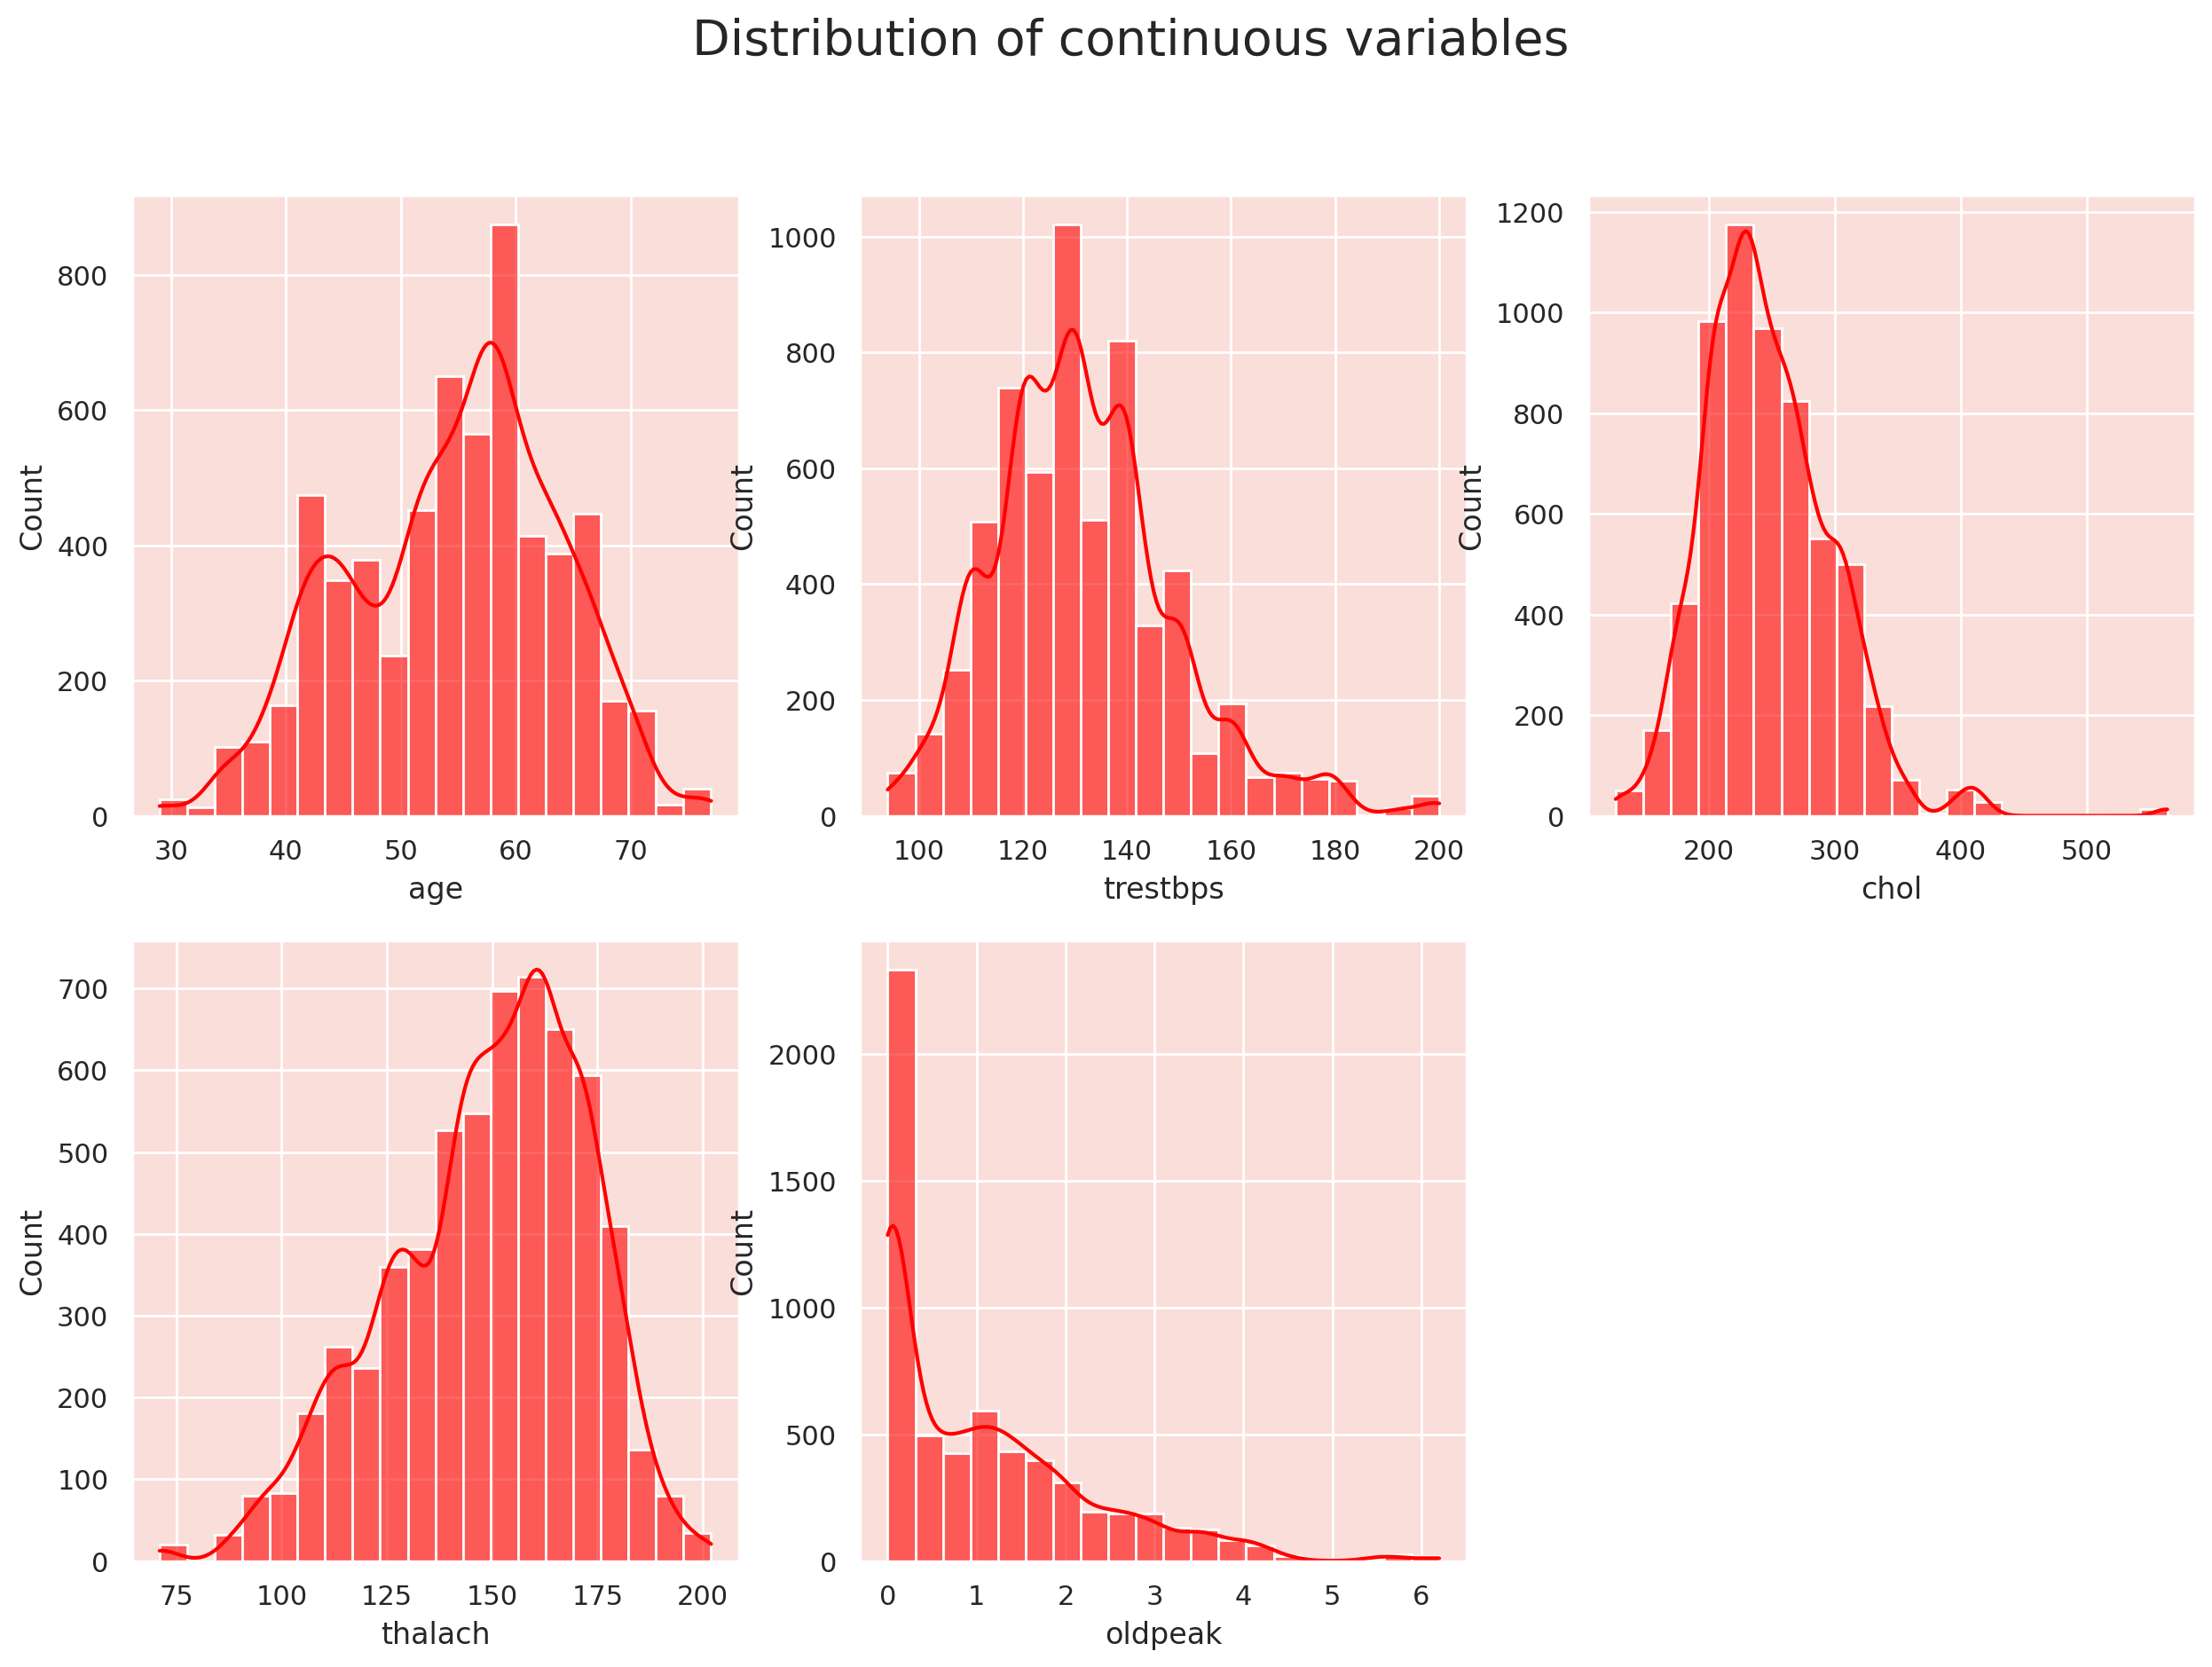

In [ ]:
# EDA GRAPHS
data_continous =data[continous_features]
fig, ax =plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for i, col in enumerate(data_continous.columns):
    x =i// 3
    y =i% 3
    sns.histplot(data=data_continous, x=col, bins=20, kde=True, ax=ax[x,y], color='red', alpha=0.6)
    ax[x,y].set_xlabel(col)
ax[1,2].axis("off")
plt.suptitle('Distribution of continuous variables', fontsize=20 )
plt.show()

Continuous features indicate clinically consistent patterns: older age, altered heart rate response, and high ST depression are more associated with heart disease.

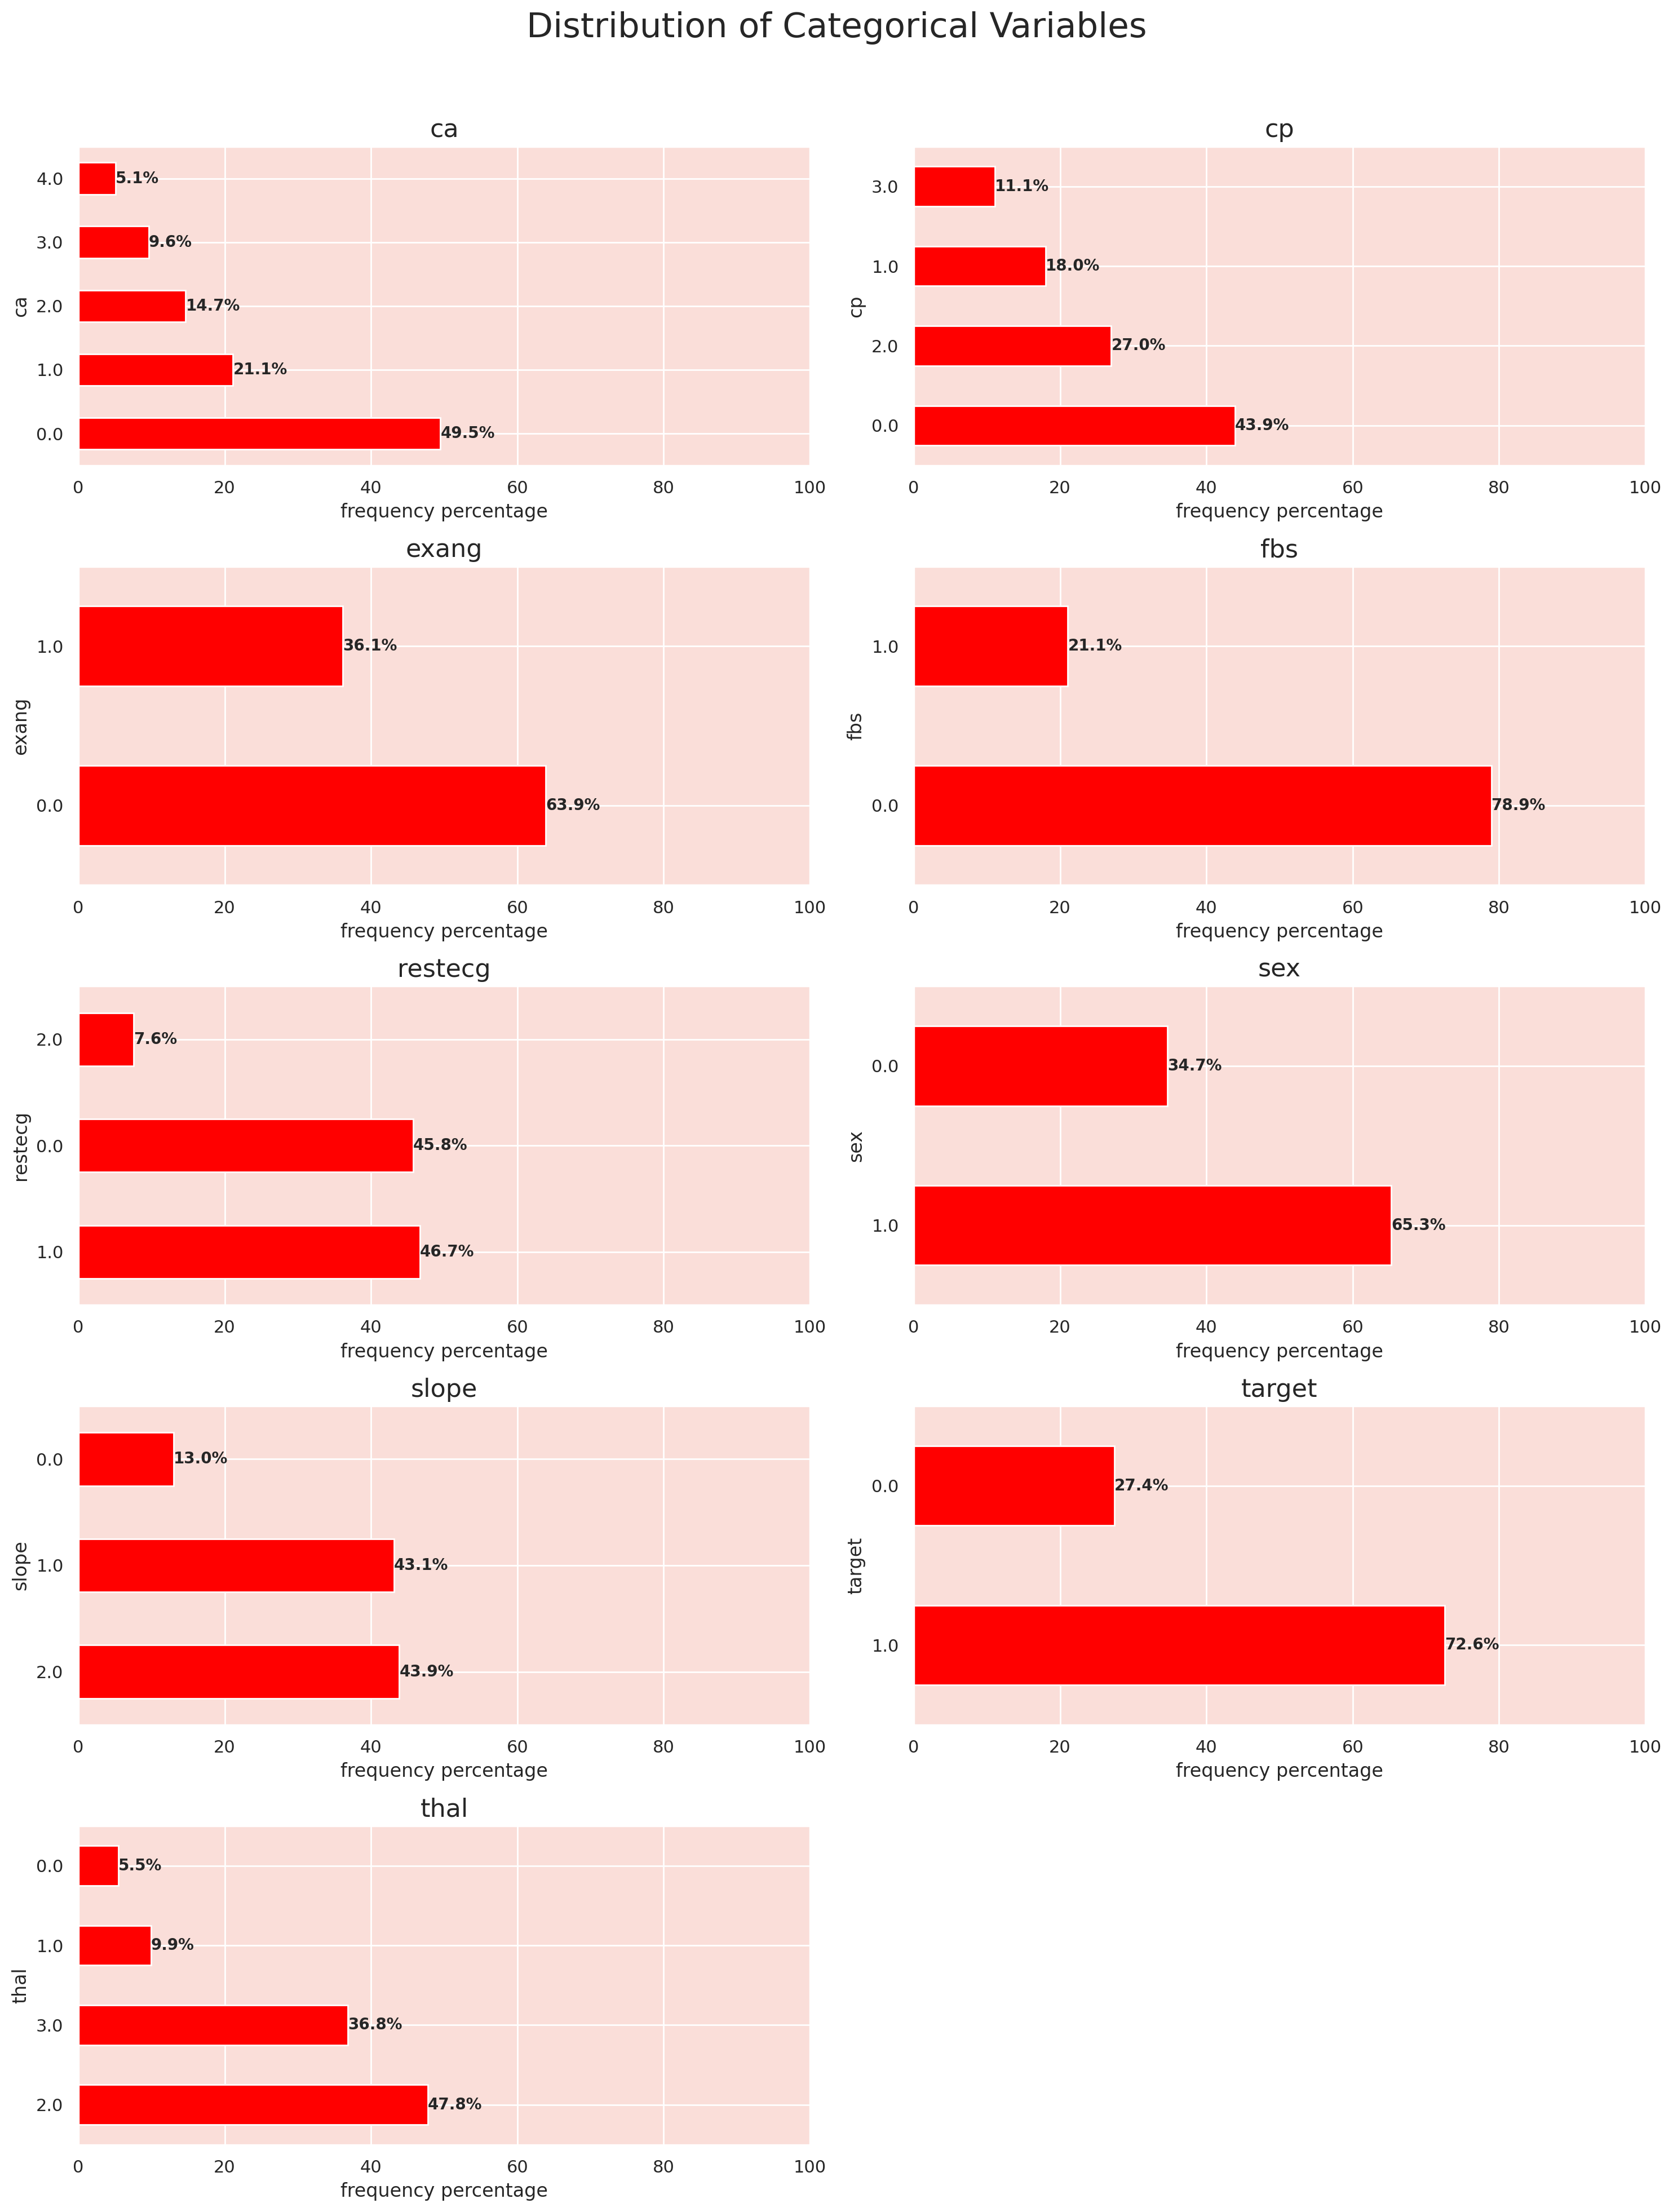

In [ ]:
# GRAPH 2: CATEGORICAL BAR CHARTS
categorical_features_for_graph = data.columns.difference(continous_features)
cat_data = data[categorical_features_for_graph]

num_categorical_features = len(categorical_features_for_graph)
num_rows = num_categorical_features // 2 + (num_categorical_features % 2)

fig, ax = plt.subplots(num_rows, 2, figsize=(15, num_rows * 4)) # Adjust figsize dynamically

for i,col in enumerate(categorical_features_for_graph):
    x=i//2; y=i%2

    current_ax = ax[x, y] if num_rows > 1 else ax[y]

    value_counts = cat_data[col].value_counts(normalize=True).mul(100)
    value_counts.plot(kind='barh', ax=current_ax, color='red')
    current_ax.set_xlim([0,100])
    current_ax.set_xlabel('frequency percentage',fontsize =12)
    current_ax.set_title(f'{col}',fontsize = 16)

    for index,value in enumerate(value_counts):
        current_ax.text(value,index,str(round(value,1))+'%',fontsize = 10,weight = 'bold',va = 'center')

if num_categorical_features % 2 != 0 and num_rows > 1:
    ax[num_rows - 1, 1].axis('off')

plt.suptitle('Distribution of Categorical Variables', fontsize =22)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

Categorical features, especially chest pain type, thal, slope, and ca, are strong diagnostic indicators and support medical reality, making them essential predictors.

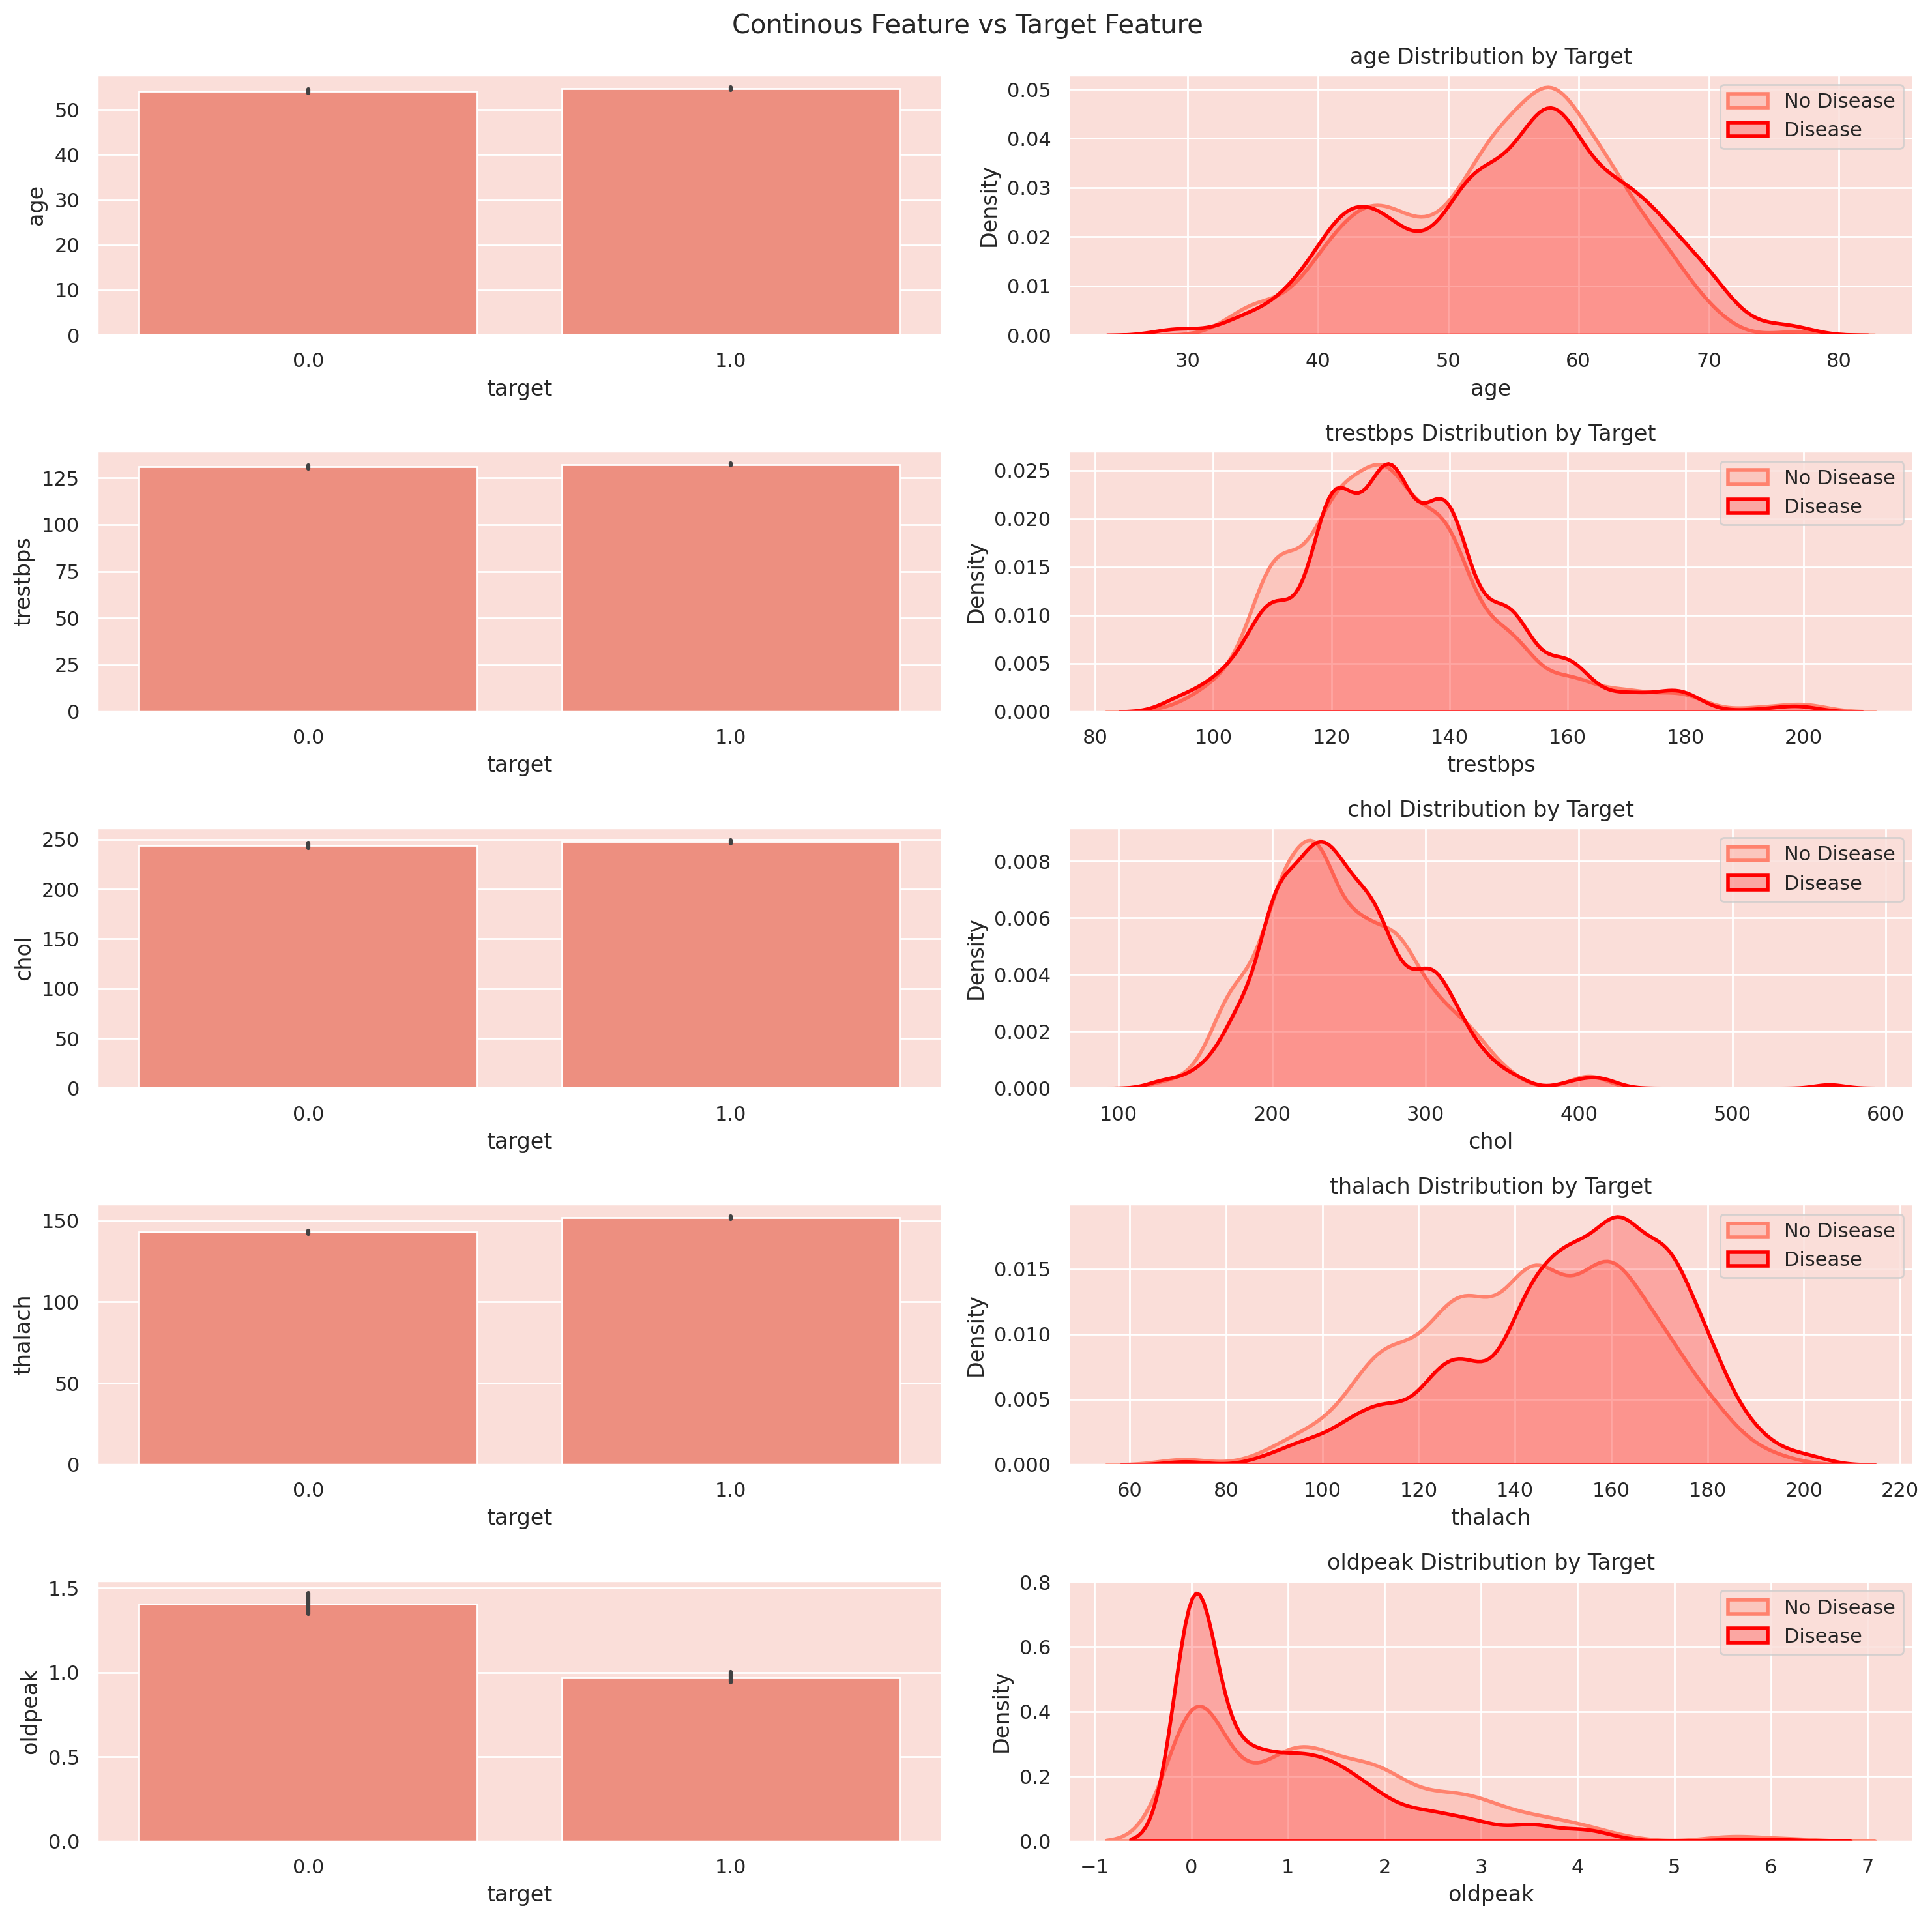

In [ ]:
# GRAPH 3: KDE PLOTS BY TARGET
sns.set_palette(['#ff826e', 'red'])
fig, ax = plt.subplots(len(continous_features),2,figsize=(15,15))
for i,col in enumerate(continous_features):
    sns.barplot(data=data,x='target',y=col,ax=ax[i,0])
    sns.kdeplot(data=data[data['target']==0],x=col,fill=True,linewidth=2,label='No Disease',ax=ax[i,1])
    sns.kdeplot(data=data[data['target']==1],x=col,fill=True,linewidth=2,label='Disease',ax=ax[i,1])
    ax[i,1].legend(loc='upper right')
    ax[i,1].set_title(f'{col} Distribution by Target')
plt.suptitle("Continous Feature vs Target Feature")
plt.tight_layout()
plt.show()


The KDE plots show that thalach (maximum heart rate) and oldpeak (ST depression) have the strongest separation between classes, indicating they are highly predictive of heart disease. Patients with heart disease generally show:

Lower thalach values, suggesting reduced cardiac performance.

Higher oldpeak values, reflecting greater ECG abnormalities.

Meanwhile, age, trestbps, and cholesterol show overlapping distributions between classes, meaning they contribute to prediction but are not strong stand-alone indicators.

In [ ]:
categorical_features = [feature for feature in all_non_continuous_features if feature != 'target']

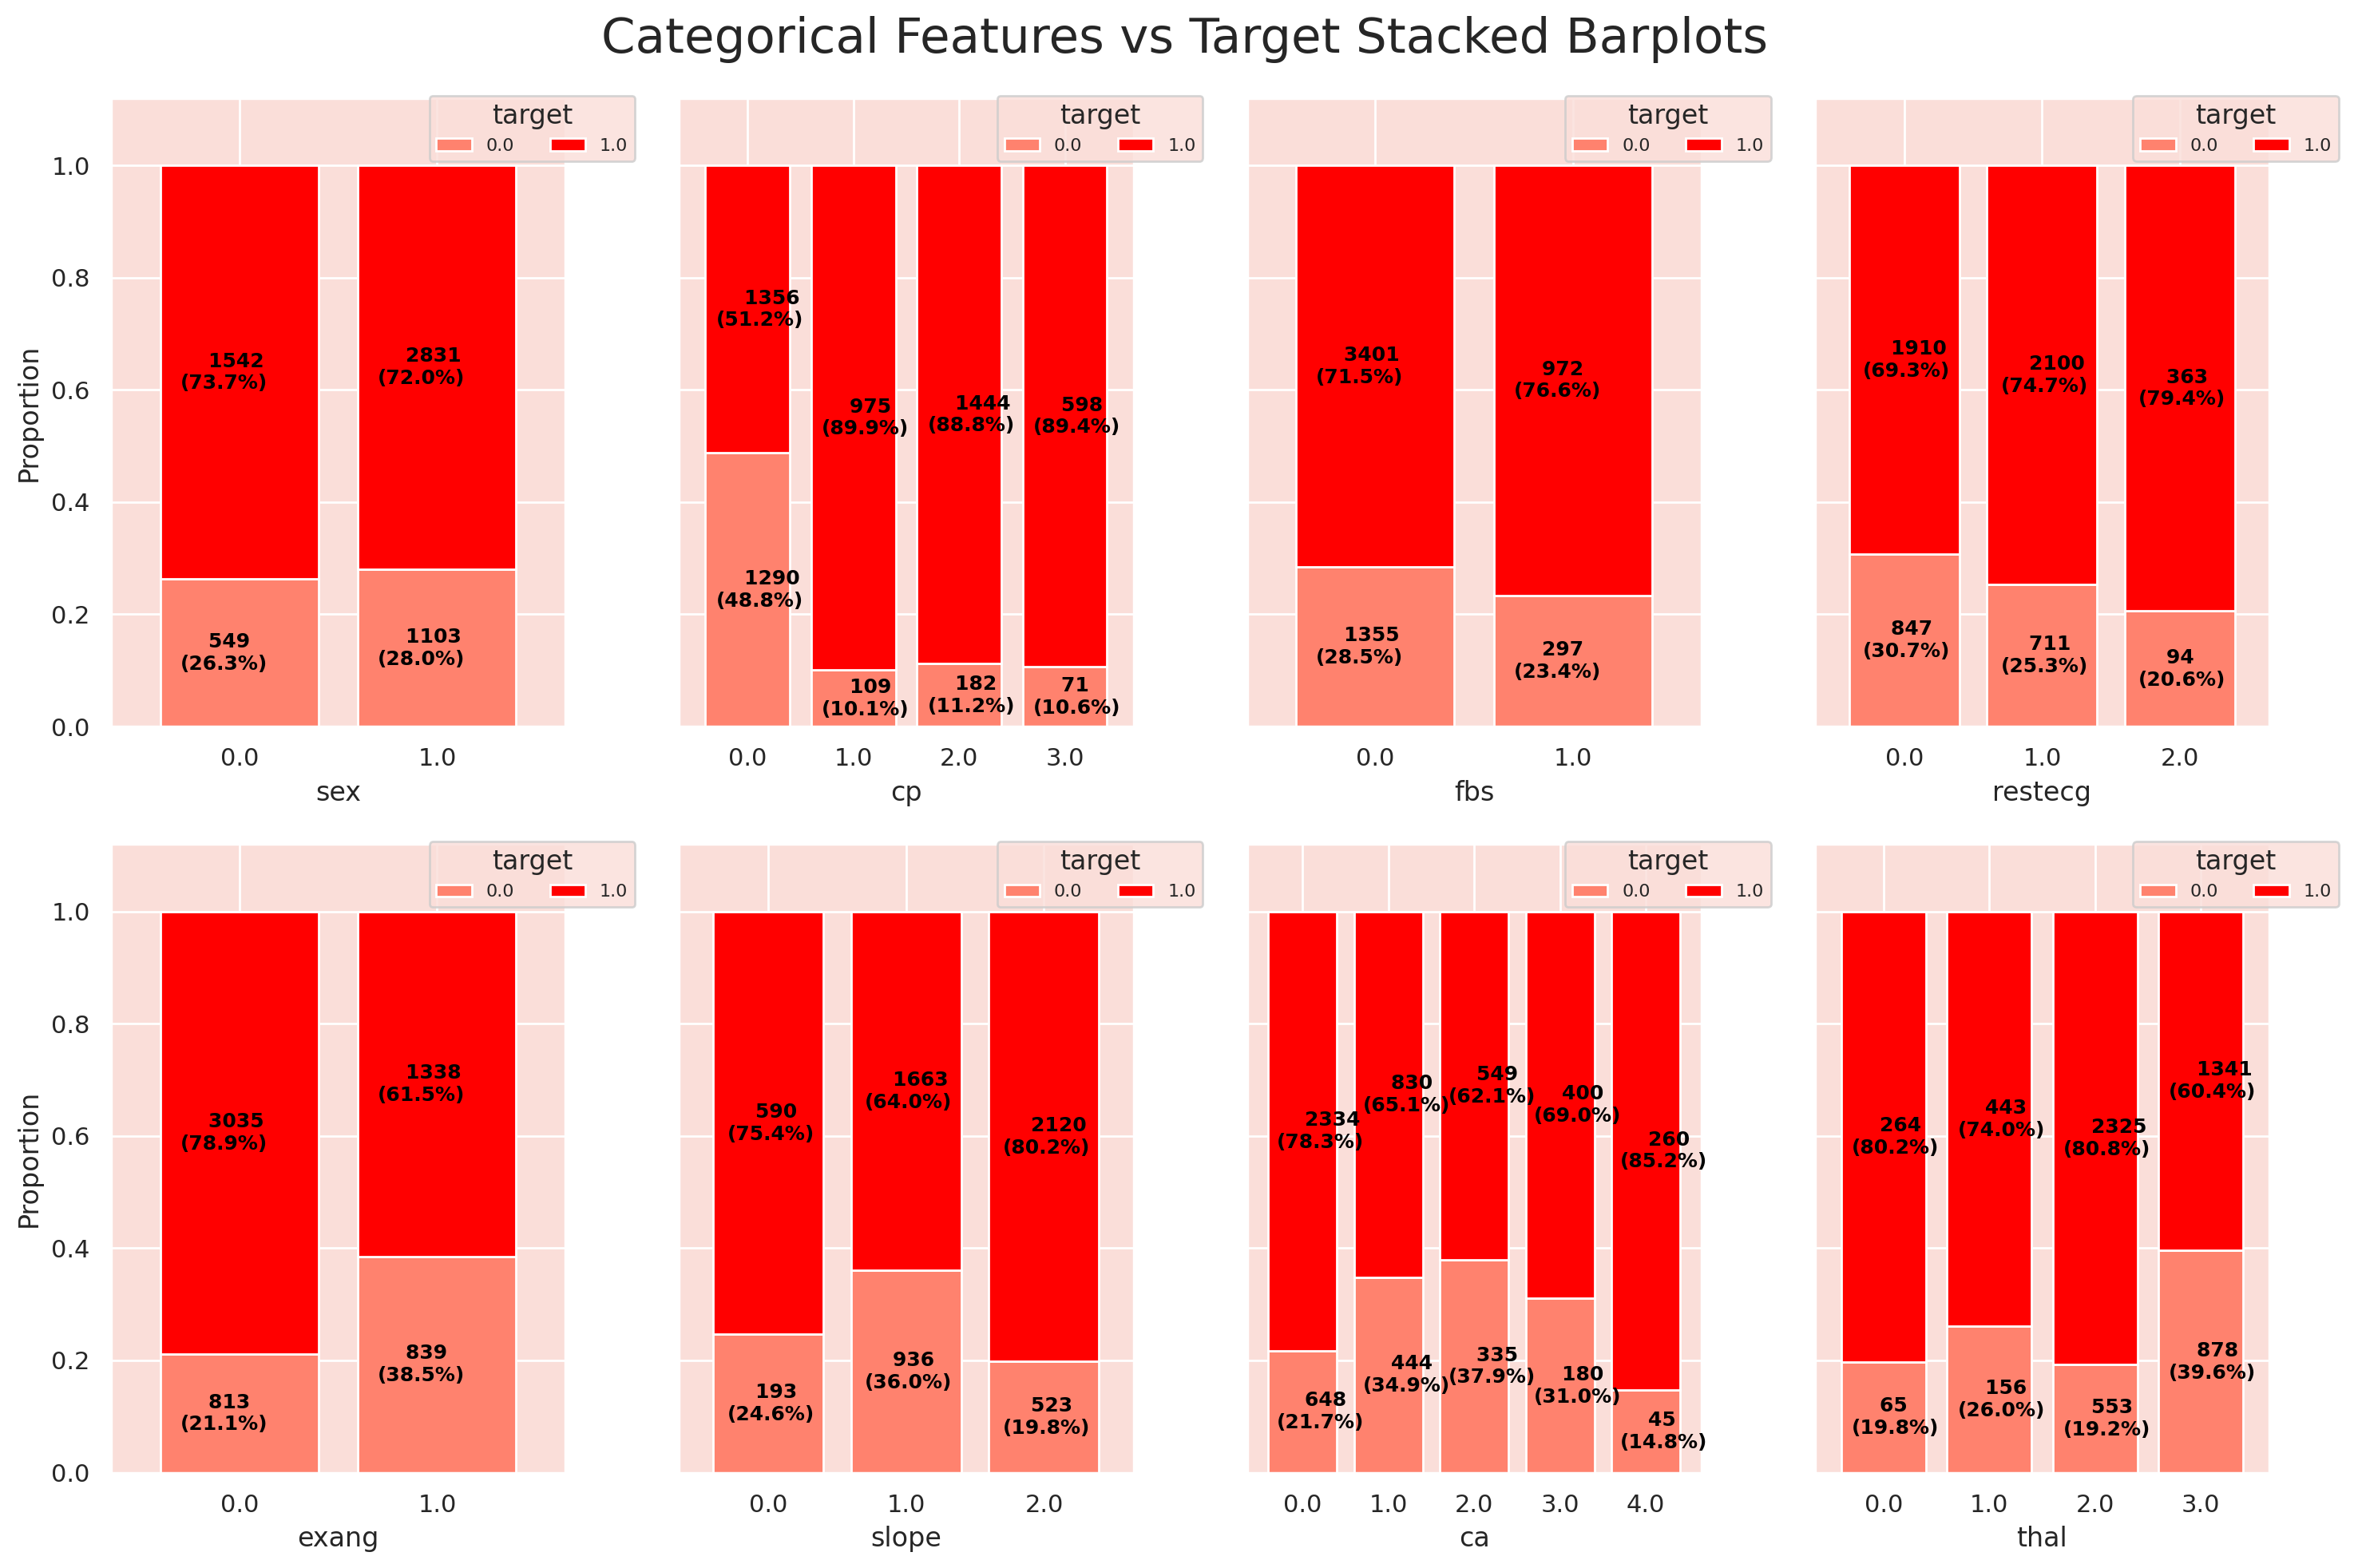

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):

    cross_tab = pd.crosstab(index=data[col], columns=data['target'])

    cross_tab_prop = pd.crosstab(index=data[col], columns=data['target'], normalize='index')

    cmp = ListedColormap(['#ff826e', 'red'])


    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)


    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)',
                         color = "black", fontsize=9, fontweight="bold")

    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)


plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()
plt.show()

Overall, the stacked bar plots reveal that cp, ca, thal, slope, and exang are strong predictors of heart disease due to the significantly higher proportion of positive cases in certain categories. Conversely, features like fbs and restecg show weaker class separation and contribute less to prediction strength.

In [ ]:
data.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
# IQR Outlier Check
for col in continous_features:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_count_specified = data[(data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))]
    print(f"{col}: {outliers_count_specified.shape[0]}")

age: 0
trestbps: 200
chol: 96
thalach: 20
oldpeak: 77


In [ ]:

# DEFINE FEATURES & TARGET
X = data.drop('target', axis=1)
y = data['target']

X_train,X_test,y_train,y_test = train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test sizes:")
X_train.shape, X_test.shape


Train/Test sizes:


((4820, 13), (1205, 13))

In [ ]:
rf_base = RandomForestClassifier(random_state=0)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])


In [ ]:
params = {
    'rf__n_estimators': [100, 200, 400],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [2, 5],
    'rf__class_weight': ['balanced']
}

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train_encoded)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 15, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}


In [ ]:
val_pred = best_model.predict(X_test)

In [ ]:
if y_test.dtype == 'object' or not y_test.dtype.kind in 'biufc':
    y_test_encoded = le.transform(y_test)
else:
    y_test_encoded = y_test.astype(int)

# Make predictions
y_pred_test = best_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred_test))

Accuracy: 0.8697095435684647
Confusion Matrix:
 [[262  68]
 [ 89 786]]


The model is very good at detecting heart disease cases (786 correct positives).

It prioritizes recall for the disease class, which is recommended in healthcare screening.

False negatives (89) should still be reduced further because missing a disease case can be risky.

In [ ]:
print("ROC-AUC Score:", roc_auc_score(y_test_encoded, y_pred_test))

ROC-AUC Score: 0.846112554112554


The ROC-AUC score of 0.8461 indicates that the model has strong discriminatory power, correctly separating patients with and without heart disease about 85% of the time. This reflects a reliable classifier that performs well in distinguishing risk levels and is suitable for early screening and medical decision support.

In [ ]:
# Evaluate the best model on the test data
from sklearn.metrics import classification_report

y_test_converted = y_test.astype(int)
y_pred_test = best_model.predict(X_test)
print(classification_report(y_test_converted, y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       330
           1       0.92      0.90      0.91       875

    accuracy                           0.87      1205
   macro avg       0.83      0.85      0.84      1205
weighted avg       0.87      0.87      0.87      1205



With 87% accuracy and strong recall for disease cases, the model is reliable for early heart disease detection and clinical risk screening.